In [1]:
# !pip install intake[complete]
# !pip install zstandard
# !pip install git+https://github.com/fsspec/kerchunk

## Creating MERRA 2 Catalog/ sidecar  jason File  
Source: https://nbviewer.org/github/peterm790/ERA5_Kerchunk_tutorial/blob/master/ERA5_tutorial.ipynb?source=post_page-----625a2d0a9191--------------------------------  

In [60]:
import requests
import fsspec

##connect with s3 credentials from earthdata 

gesdisc_s3_url = "https://data.gesdisc.earthdata.nasa.gov/s3credentials"

def begin_s3_direct_access(url: str=gesdisc_s3_url):
    response = requests.get(url).json()
    
    s3_options = {
        "key": response['accessKeyId'],
        "secret": response['secretAccessKey'],
        "token": response['sessionToken'],
        "client_kwargs": {'region_name': 'us-west-2'}
    }
    
    return fsspec.filesystem("s3", **s3_options)

s3fs = begin_s3_direct_access()

# Check that the file system is intact as an S3FileSystem object, which means that token is valid
# Common causes of rejected S3 access tokens include incorrect passwords stored in the netrc file, or a non-existent netrc file
type(s3fs)


s3fs.core.S3FileSystem

In [62]:
s3_flist = s3fs.glob("s3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/*.nc4") #april-2023
s3_flist

['gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190401.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190402.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190403.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190404.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190405.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190406.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190407.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190408.nc4',
 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/04/MERRA2_400.tavg1_2d_slv_Nx.20190409.nc4',
 'gesdisc-cumulus-prod-protected/MERR

In [63]:
#create local fs to save sidecar files
local_fs = fsspec.filesystem('') 

## Create a sidecar for each file which will later be consolidate into a single file

In [64]:
from pathlib import Path
import os
import ujson
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr
# import fsspec.implementations.reference
# from fsspec.implementations.reference import LazyReferenceMapper
import xarray as xr

In [6]:
# JCC: create ref catalog in s3/eso-west2-curated/./.

In [65]:
cd /home/jovyan/efs

/home/jovyan/efs


In [66]:
# os.mkdir('MERRA2_jsons') # creates dir in current working diretory

json_dir = 'efs/MERRA2_jsons/'

file_open_config = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first')

In [8]:
# file_open_config helps save parameters used to configure the file opening operation- in generate_json function
# file_open_config: {'mode': 'rb', 
#                    'anon': True, 
#                    'default_fill_cache': False, 
#                    'default_cache_type': 'first'
#                   }
# path [0] = gesdisc-cumulus-prod-protected/
# path [1] = MERRA2/
# path [2] = M2T1NXSLV.5.12.4/
# year [3] = 2019/
# month [4] = 03/
# stem [5] =  MERRA2_400.tavg1_2d_slv_Nx.2019MMDD

In [70]:
def generate_json(path):
    with s3fs.open(path, **file_open_config) as infile:
        h5chunks = SingleHdf5ToZarr(infile, path, inline_threshold=300)
        parts = path.split('/') # seperate file path to create a unique name for each json 
        # year = parts[3]
        # month = parts[4]
        fstem = Path(path).stem # .stem retreives the base name of the file path without its extension, this already includes year/month/day
        outf = f'{json_dir}{fstem}.json' #removed redundant {year}{month}
        print(outf)
        with local_fs.open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());

In [26]:
#check to make sure you are in the correct directory (cd /home/jovyan/)

In [72]:
%%time
for file in s3_flist:
    generate_json(file)

efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190401.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190402.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190403.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190404.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190405.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190406.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190407.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190408.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190409.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190410.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190411.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190412.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190413.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190414.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190415.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190416.json
efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190417.json
efs/MERRA2_jso

In [73]:
# Check files 
json_list = local_fs.glob(str(json_dir)+'MERRA2_400.tavg1_2d_slv_Nx.*.json')

In [74]:
json_list

['/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190401.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190402.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190403.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190404.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190405.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190406.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190407.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190408.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190409.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190410.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190411.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190412.json',
 '/home/jovyan/efs/MERRA2_jsons/MERRA2_400.tavg1_2d_slv_Nx.20190413.json',
 '/home/jovyan/efs/MERRA2

### using kerchunk.combine.MultiZarrtoZarr to consolidate to a sidecar file

In [147]:
## How else can I try passing credentials to workers to access data and avoid Nan data error?


In [148]:
%%time
fs_ = fsspec.filesystem("reference", 
                        fo=json_list[0], 
                        ref_storage_args={'skip_instance_cache':True},
                        remote_protocol='s3', 
                        remote_options={'anon':False, 'fs': s3fs}
                       )

CPU times: user 24.7 ms, sys: 0 ns, total: 24.7 ms
Wall time: 33.5 ms


#### Checking contents of fs_: 
```
file_list = fs_.ls('')
file_list output is a list of dictionaries: 
    [{'name': '.zgroup', 'type': 'file', 'size': 17},
     {'name': '.zattrs', 'type': 'file', 'size': 1363},
     {'name': 'CLDPRS', 'type': 'directory', 'size': 0},
     {'name': 'CLDTMP', 'type': 'directory', 'size': 0},
     {'name': 'DISPH', 'type': 'directory', 'size': 0}  
     ...
    ]
```

  - **name** key specifies the name of the file or directory.
  - **type** key specifies whether the item is a file or directory.
  - **size** key specifies the size of the item. For directories, the size is typically 0.  
  
Output confirms that the credentials used to access the remote filesystem were accepted

In [149]:
## check to see what may be causing the Nan -> Rich suggested this may be due to not having credentials set on the workers to access the data

mapper_obj = fs_.get_mapper("")
## what exactly is get_mapper doing? -> mapper expects a path argument, which specifies the location 
## within the filesystem for which the mapper is obtained. This could be a directory path, file path, 
## or other resource identifier depending on the filesystem type. an empty "" string, directs it to root directory 

In [159]:
print((mapper_obj))

In [160]:
ds = xr.open_dataset(mapper_obj, 
                     engine="zarr", 
                     backend_kwargs={'consolidated':False}, 
                     chunks={}
                    )
print(ds)

<xarray.Dataset>
Dimensions:   (time: 24, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * lon       (lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * time      (time) datetime64[ns] 2019-04-01T00:30:00 ... 2019-04-01T23:30:00
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    CLDTMP    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    DISPH     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H1000     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H500      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ...        ...
    V250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V

In [156]:
print(ds)

<xarray.Dataset>
Dimensions:   (time: 24, lat: 361, lon: 576)
Coordinates:
  * lat       (lat) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * lon       (lon) float64 nan nan nan nan nan nan ... nan nan nan nan nan nan
  * time      (time) datetime64[ns] 2019-04-01T00:30:00 ... 2019-04-01T23:30:00
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    CLDTMP    (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    DISPH     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H1000     (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    H500      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    ...        ...
    V250      (time, lat, lon) float32 dask.array<chunksize=(1, 91, 144), meta=np.ndarray>
    V

In [31]:
val=ds.V2M.mean().values
val

array(nan, dtype=float32)

In [ ]:
# fix lat and lon fill_value in post_process method
# Question: What fill value to use? using lon = 576 and lat = 361, going off https://goldsmr4.gesdisc.eosdis.nasa.gov/data/MERRA2_MONTHLY/M2C0NXASM.5.12.4/doc/MERRA2.README.pdf  for now
#rerun with the new values 
import zarr
def modify_fill_value(out):
    out_ = zarr.open(out)
    out_.lon.fill_value = -1e20
    out_.lat.fill_value = -1e20
    return out

def postprocess(out):
    out = modify_fill_value(out)
    return out

In [34]:
mzz = MultiZarrToZarr(json_list,                
    remote_protocol='s3',
    remote_options={'anon':True},
    concat_dims=['time'], #this is the dimension along which the individual files will be merged
    postprocess = postprocess
)

In [38]:
# mzz.translate() calls GetObject which is causing an Access Denied ClientError due to permissions
'''
ReferenceNotReachable: Reference "DISPH/0.0.0" failed to fetch target ['gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190301.nc4', 93284, 252]

TODO: 
    check what .translate() is doing 
        -> why is it calling s3 if it has json files in efs? 
        -> is the access denied error due to time out of credentials or because of the GetObject? 
    
'''

In [ ]:
%%time
d = mzz.translate()

In [ ]:
with fs2.open('combined.json', 'wb') as f:
    f.write(ujson.dumps(d).encode())

## USING MEDIUM INTAKE NOTEBOOK RECIPE 
source: 

In [ ]:
import intake
import xarray


## MERRA 2 Data Access Walkthrough // Expected Output
Source: https://disc.gsfc.nasa.gov/information/howto?keywords=%22Earthdata%20Cloud%22&title=How%20to%20Directly%20Access%20MERRA-2%20Data%20from%20an%20S3%20Bucket%20with%20Python%20from%20a%20Cloud%20Environment

In [12]:
from netrc import netrc
from subprocess import Popen
from platform import system
from getpass import getpass
import xarray as xr
import boto3
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import warnings
from IPython.display import display, Markdown


warnings.filterwarnings('ignore')
%matplotlib inline

In [14]:
fn = 's3://gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4'

fs.info(fn)

{'Key': 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4',
 'LastModified': datetime.datetime(2021, 3, 18, 23, 32, 5, tzinfo=tzlocal()),
 'ETag': '"ab39493d3182642efbf610439b3d1d29-2"',
 'Size': 415071782,
 'StorageClass': 'STANDARD',
 'type': 'file',
 'size': 415071782,
 'name': 'gesdisc-cumulus-prod-protected/MERRA2/M2T1NXSLV.5.12.4/2019/03/MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4'}

In [15]:
ds = xr.open_dataset(fs.open(fn), decode_cf=True,)

# Subset SLP at 15:30Z, convert units
slp = ds.SLP.values[15,:,:] / 100 # convert to hPa

slp

array([[ 985.77765,  985.77765,  985.77765, ...,  985.77765,  985.77765,
         985.77765],
       [ 985.1326 ,  985.1326 ,  985.1326 , ...,  985.13763,  985.13763,
         985.1326 ],
       [ 983.9426 ,  983.9377 ,  983.9377 , ...,  983.95264,  983.94763,
         983.94763],
       ...,
       [1007.2477 , 1007.26013, 1007.27014, ..., 1007.21014, 1007.22266,
        1007.23517],
       [1007.67017, 1007.6752 , 1007.6777 , ..., 1007.65765, 1007.66266,
        1007.66516],
       [1007.97766, 1007.97766, 1007.97766, ..., 1007.97766, 1007.97766,
        1007.97766]], dtype=float32)

In [16]:
ds 

<xarray.Dataset>
Dimensions:   (lon: 576, lat: 361, time: 24)
Coordinates:
  * lon       (lon) float64 -180.0 -179.4 -178.8 -178.1 ... 178.1 178.8 179.4
  * lat       (lat) float64 -90.0 -89.5 -89.0 -88.5 ... 88.5 89.0 89.5 90.0
  * time      (time) datetime64[ns] 2019-03-13T00:30:00 ... 2019-03-13T23:30:00
Data variables: (12/47)
    CLDPRS    (time, lat, lon) float32 ...
    CLDTMP    (time, lat, lon) float32 ...
    DISPH     (time, lat, lon) float32 ...
    H1000     (time, lat, lon) float32 ...
    H250      (time, lat, lon) float32 ...
    H500      (time, lat, lon) float32 ...
    ...        ...
    V250      (time, lat, lon) float32 ...
    V2M       (time, lat, lon) float32 ...
    V500      (time, lat, lon) float32 ...
    V50M      (time, lat, lon) float32 ...
    V850      (time, lat, lon) float32 ...
    ZLCL      (time, lat, lon) float32 ...
Attributes: (12/30)
    History:                           Original file generated: Sat Mar 23 22...
    Comment:                           GMAO filename: d5124_m2_jan10.tavg1_2d...
    Filename:                          MERRA2_400.tavg1_2d_slv_Nx.20190313.nc4
    Conventions:                       CF-1
    Institution:                       NASA Global Modeling and Assimilation ...
    References:                        http://gmao.gsfc.nasa.gov
    ...                                ...
    Contact:                           http://gmao.gsfc.nasa.gov
    identifier_product_doi:            10.5067/VJAFPLI1CSIV
    RangeBeginningDate:                2019-03-13
    RangeBeginningTime:                00:00:00.000000
    RangeEndingDate:                   2019-03-13
    RangeEndingTime:                   23:59:59.000000

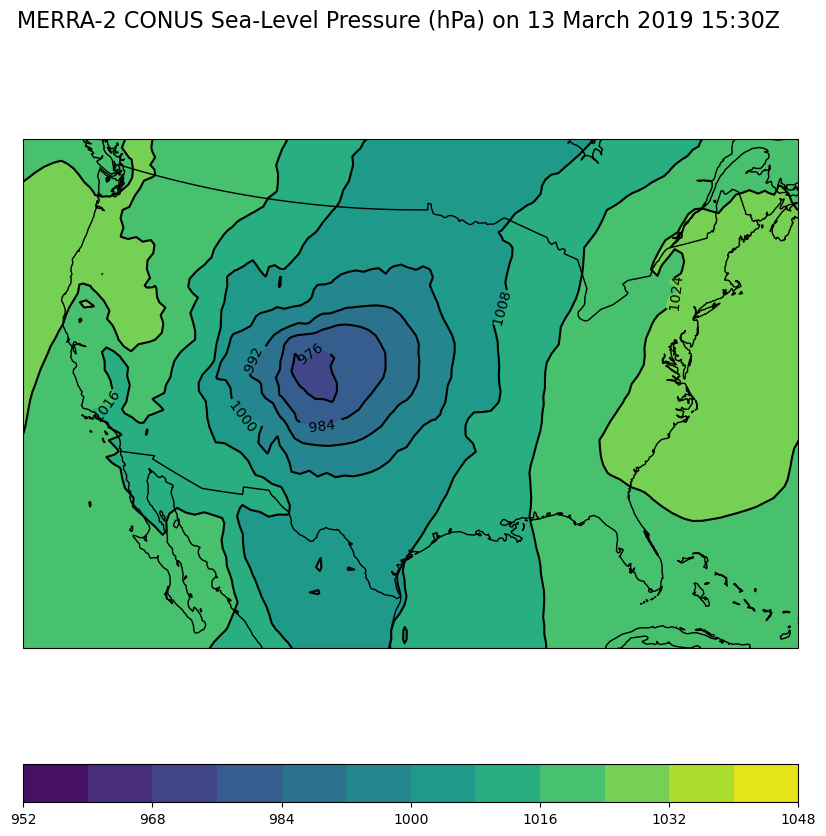

In [9]:
plt.rcParams['figure.figsize'] = 10,10

# Set up figure
fig = plt.figure()

ax = fig.add_subplot(111, projection=ccrs.LambertConformal())
ax.set_extent([-121, -72, 23, 51], crs=ccrs.PlateCarree()) # CONUS extent
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.BORDERS)

# Set up filled and line contours
filled_c = ax.contourf(ds.lon, ds.lat, slp, levels=10, 
                       transform=ccrs.PlateCarree())
line_c = ax.contour(ds.lon, ds.lat, slp, levels=10,
                        colors=['black'],
                        transform=ccrs.PlateCarree())

# Set up labelling for contours
ax.clabel(line_c,  
    colors=['black'],
    manual=False,  
    inline=True,  
    fmt=' {:.0f} '.format,  
    )

# Set up colorbar and figure title
fig.colorbar(filled_c, orientation='horizontal')
fig.suptitle('MERRA-2 CONUS Sea-Level Pressure (hPa) on 13 March 2019 15:30Z', fontsize=16)

plt.show()